<a href="https://colab.research.google.com/github/rifqoi/Inacure-Machine-Learning/blob/main/03-ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [2]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

# List directories for each datasets

In [3]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

# List Images

In [4]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Pepaya: 
 	168 train images, 47 validation images, and 25 test images,  total 240 images

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images

Jambu Biji: 
 	338 train images, 96 validation images, and 50 test images,  total 484 images

Jamblang: 
 	226 train images, 64 validation images, and 34 test images,  total 324 images

Delima: 
 	251 train images, 71 validation images, and 37 test images,  total 359 images

Anggur: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Kedelai: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Apel: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Ceri: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images



# Create a model class to prevent code redundancy

In [5]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                rotation_range = 25,
                                zoom_range = [0.5, 1.1],
                                width_shift_range=0.15, 
                                shear_range= 0.15,
                                height_shift_range=0.15,
                                preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                vertical_flip= True,
                                fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,
                                            preprocessing_function=preprocess_input)
  
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config, custom_layer = None):

    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    layers = []
    
    # Append base model to layers_list
    layers.append(self.base_model)

    flatten_layer = tf.keras.layers.Flatten()
    layers.append(flatten_layer)

    if custom_layer is None:
      layers.append(tf.keras.layers.Dense(512, activation='relu'))
    else: 
      for layer in custom_layer:
        layers.append(layer)
    
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    layers.append(prediction_layer)

    self.model = tf.keras.models.Sequential(layers)

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

# VGG16 


## Build Model

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 10,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(),
    "metrics": ["acc"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
vgg16.trainable = False

vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config, custom_layer=custom_layer)

Found 2410 images belonging to 10 classes.
Found 678 images belonging to 10 classes.
Found 361 images belonging to 10 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dense_5 (Dense)             (None, 1024)              525312    
                                                                 
 dense_6 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_7 (Dense)             (None, 10)                1025

## Train Model

In [9]:
vgg16_model.train(model_name='vgg16')

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 1.4582 - acc: 0.5245 
Epoch 1: val_acc improved from -inf to 0.85103, saving model to vgg16-saved-model-01-acc-0.85.hdf5
76/76 [==============================] - 2189s 29s/step - loss: 1.4582 - acc: 0.5245 - val_loss: 0.3975 - val_acc: 0.8510
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.5750 - acc: 0.7863
Epoch 2: val_acc improved from 0.85103 to 0.90265, saving model to vgg16-saved-model-02-acc-0.90.hdf5
76/76 [==============================] - 450s 6s/step - loss: 0.5750 - acc: 0.7863 - val_loss: 0.2631 - val_acc: 0.9027
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.4294 - acc: 0.8390
Epoch 3: val_acc did not improve from 0.90265
76/76 [==============================] - 442s 6s/step - loss: 0.4294 - acc: 0.8390 - val_loss: 0.2756 - val_acc: 0.8982
Epoch 4/20
76/76 [==============================] - ETA: 0s - loss: 0.3625 - acc: 0.8668
Epoch 4: val_acc improved from 0.9

## History

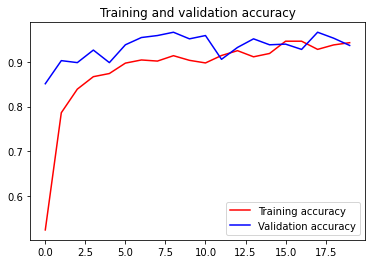

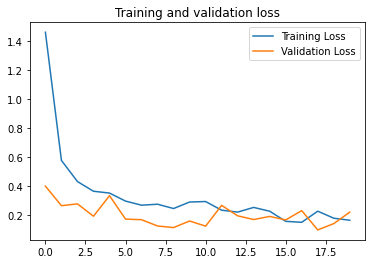

In [10]:
vgg16_model.plot_history()

## Evaluate Model

12/12 [==============================] - 303s 28s/step - loss: 0.3643 - acc: 0.9169
Loss of the model is -  0.36428678035736084
Accuracy of the model is -  91.68975353240967 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       1.00      0.95      0.97        37
        Ceri       1.00      0.95      0.97        37
      Delima       0.82      1.00      0.90        37
    Jamblang       0.97      0.82      0.89        34
  Jambu Biji       0.80      0.90      0.85        50
     Kedelai       0.90      1.00      0.95        37
       Lemon       0.72      0.57      0.63        23
      Mangga       0.98      0.89      0.93        45
      Pepaya       1.00      1.00      1.00        24

    accuracy                           0.92       361
   macro avg       0.92      0.91      0.91       361
weighted avg       0.92      0.92      0.92       361

Confusion Matrix


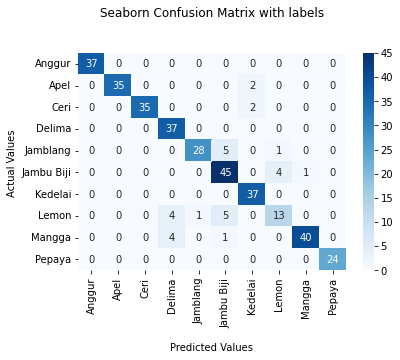

In [11]:
vgg16_model.evaluate_model()

In [12]:
vgg16_model.model.save_weights("/content/vgg16-saved-model-20-acc-0.93.hdf5")

In [14]:
!cp "/content/vgg16-saved-model-20-acc-0.93.hdf5" "/content/drive/Shareddrives/Bangkit Capstone/Best Model2"

In [15]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

./vgg16-saved-model-09-acc-0.97.hdf5


## Evaluate Best Model

In [ ]:
vgg16_model.model.save("asd", save_format='tf')

INFO:tensorflow:Assets written to: asd/assets


12/12 [==============================] - 49s 4s/step - loss: 0.1758 - acc: 0.9446
Loss of the model is -  0.17579808831214905
Accuracy of the model is -  94.45983171463013 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       0.89      0.92      0.91        37
        Ceri       1.00      0.95      0.97        37
      Delima       0.90      1.00      0.95        37
    Jamblang       1.00      0.94      0.97        34
  Jambu Biji       0.92      0.90      0.91        50
     Kedelai       0.88      1.00      0.94        37
       Lemon       1.00      0.74      0.85        23
      Mangga       0.96      0.96      0.96        45
      Pepaya       0.96      1.00      0.98        24

    accuracy                           0.94       361
   macro avg       0.95      0.94      0.94       361
weighted avg       0.95      0.94      0.94       361

Confusion Matrix


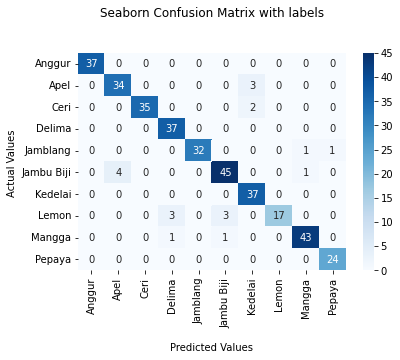

In [16]:
vgg16_model.evaluate_best_model()

# InceptionV3 (sucks)

## Build Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
for layer in inceptionv3.layers[:249]:
   layer.trainable = False
for layer in inceptionv3.layers[249:]:
   layer.trainable = True

custom_layer = [
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config, custom_layer=custom_layer)

Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_33 (Dense)            (None, 512)               26214912  
                                                                 
 dense_34 (Dense)            (None, 1024)              525312    
                                                                 
 dense_35 (Dense)            (None, 1024)              104960

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.5567 - acc: 0.3926
Epoch 1: val_acc improved from -inf to 0.30445, saving model to inceptionv3-saved-model-01-acc-0.30.hdf5
48/48 [==============================] - 235s 5s/step - loss: 1.5567 - acc: 0.3926 - val_loss: 1.7362 - val_acc: 0.3044 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.2836 - acc: 0.4947
Epoch 2: val_acc improved from 0.30445 to 0.48478, saving model to inceptionv3-saved-model-02-acc-0.48.hdf5
48/48 [==============================] - 226s 5s/step - loss: 1.2836 - acc: 0.4947 - val_loss: 1.3601 - val_acc: 0.4848 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.1994 - acc: 0.5244
Epoch 3: val_acc improved from 0.48478 to 0.49180, saving model to inceptionv3-saved-model-03-acc-0.49.hdf5
48/48 [==============================] - 227s 5s/step - loss: 1.1994 - acc: 0.5244 - val_loss: 1.2302 - val_acc: 0.4918 - lr: 1.0000e-04
E

## History

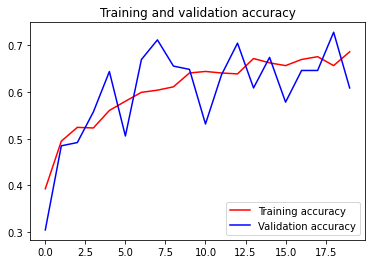

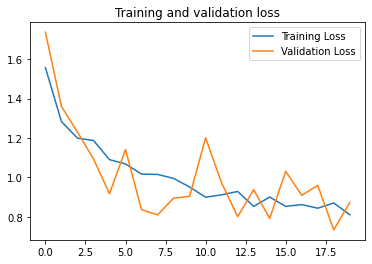

In [ ]:
iv3_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 29s - loss: 11.1516 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 8.4691 - acc: 0.1027
Loss of the model is -  8.469086647033691
Accuracy of the model is -  10.26785746216774 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.95      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.50      0.08      0.14        24

    accuracy                           0.10       224
   macro avg       0.07      0.13      0.04       224
weighted avg       0.06      0.10      0.03       224

Confusion Matrix


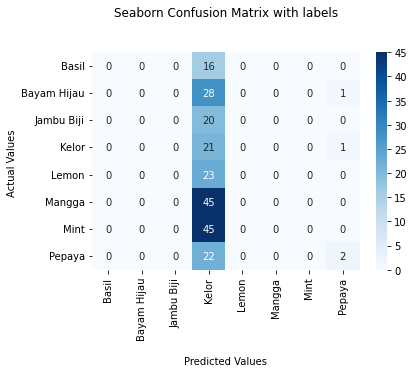

In [ ]:
iv3_model.evaluate_model()

## Evaluate Best Model

./inceptionv3-saved-model-19-acc-0.73.hdf5
1/7 [===>..........................] - ETA: 29s - loss: 11.4252 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 3s/step - loss: 8.7554 - acc: 0.1295
Loss of the model is -  8.755419731140137
Accuracy of the model is -  12.94642835855484 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.86      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.37      0.42      0.39        24

    accuracy                           0.13       224
   macro avg       0.06      0.16      0.07       224
weighted avg       0.05      0.13      0.06       224

Confusion Matrix


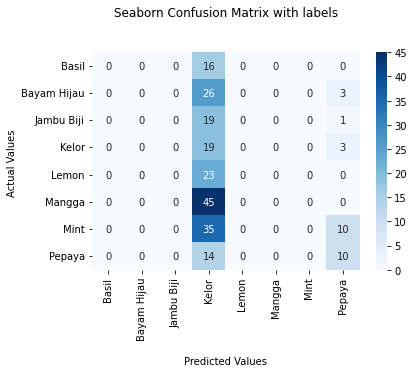

In [ ]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-06-acc-0.68.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# ResNet50

## Build Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(lr=1e-4),
    "metrics": ["accuracy"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
resnet50.trainable = False
resnet50_model = Model(model=resnet50, config=config)
resnet50_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=resnet50_preprocess_input)
resnet50_model.build_model(compile_config, custom_layer=custom_layer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


94781440/94765736 [==============================] - 1s 0us/step
Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_13 (Flatten)        (None, 100352)            0         
                                                                 
 dense_37 (Dense)            (None, 512)               51380736  
                                                                 
 dense_38 (Dense)            (None, 1024)              525312    
                                                                 
 dense_39 (Dense)            (None, 1024)              1049600   
                                                              

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
resnet50_model.train('resnet50', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.8786 - acc: 0.3142
Epoch 1: val_acc improved from -inf to 0.42623, saving model to resnet50-saved-model-01-acc-0.43.hdf5
48/48 [==============================] - 234s 5s/step - loss: 1.8786 - acc: 0.3142 - val_loss: 1.5219 - val_acc: 0.4262 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.6161 - acc: 0.3748
Epoch 2: val_acc did not improve from 0.42623
48/48 [==============================] - 223s 5s/step - loss: 1.6161 - acc: 0.3748 - val_loss: 1.5354 - val_acc: 0.4239 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.4853 - acc: 0.4130
Epoch 3: val_acc improved from 0.42623 to 0.44028, saving model to resnet50-saved-model-03-acc-0.44.hdf5
48/48 [==============================] - 225s 5s/step - loss: 1.4853 - acc: 0.4130 - val_loss: 1.4317 - val_acc: 0.4403 - lr: 1.0000e-04
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 1

## History

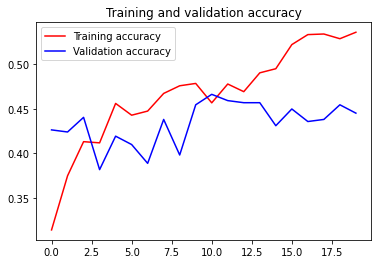

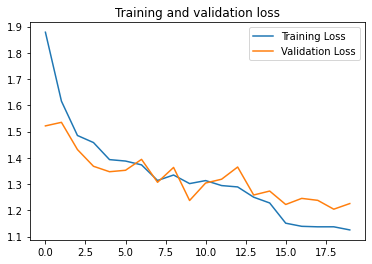

In [ ]:
resnet50_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 31s - loss: 1.6835 - acc: 0.0938

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 1.3344 - acc: 0.4554
Loss of the model is -  1.33437979221344
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.23      0.10      0.14        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.26      0.77      0.39        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.51      0.51      0.51        45
      Pepaya       0.54      0.58      0.56        24

    accuracy                           0.46       224
   macro avg       0.27      0.37      0.29       224
weighted avg       0.34      0.46      0.37       224

Confusion Matrix


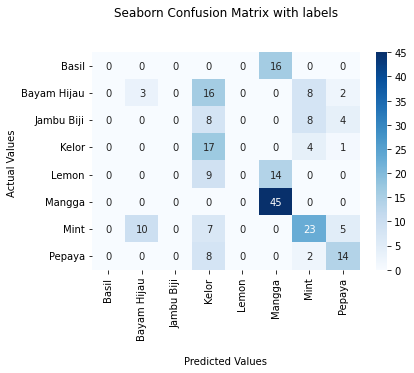

In [ ]:
resnet50_model.evaluate_model()

## Evaluate Best Model

./resnet50-saved-model-11-acc-0.47.hdf5
1/7 [===>..........................] - ETA: 31s - loss: 1.8790 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 25s 3s/step - loss: 1.3031 - acc: 0.4554
Loss of the model is -  1.3030669689178467
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.24      0.59      0.34        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.52      0.53      0.53        45
      Pepaya       0.45      0.83      0.59        24

    accuracy                           0.46       224
   macro avg       0.23      0.37      0.28       224
weighted avg       0.30      0.46      0.35       224

Confusion Matrix


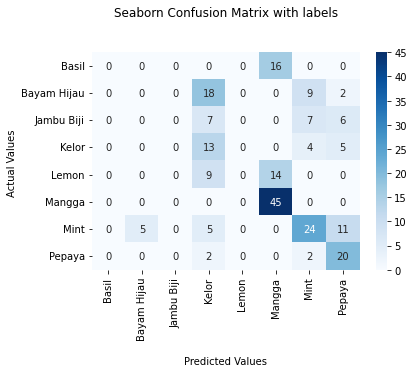

In [ ]:
resnet50_model.model_name = 'resnet50'
resnet50_model.find_best_model('.')
resnet50_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
resnet50_model.save_best_model(target_dir=target_dir)

Copy ./resnet50-saved-model-11-acc-0.47.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# VGG19

## Build Model

In [50]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 10,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(),
    "metrics": ["accuracy"],
}
vgg19 = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=config['input_shape'],
)

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
]

vgg19.trainable = False
vgg19_model = Model(model=vgg19, config=config)
vgg19_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg19_preprocess_input)
vgg19_model.build_model(compile_config, custom_layer)

80150528/80134624 [==============================] - 1s 0us/step
Found 2410 images belonging to 10 classes.
Found 678 images belonging to 10 classes.
Found 361 images belonging to 10 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               12845568  
                                                                 
 dense_9 (Dense)             (None, 1024)              525312    
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                            

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg19_model.train('vgg19', reduce_lr_config=reduce_lr_config)

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 1.5361 - acc: 0.5212
Epoch 1: val_acc improved from -inf to 0.73894, saving model to vgg19-saved-model-01-acc-0.74.hdf5
76/76 [==============================] - 461s 6s/step - loss: 1.5361 - acc: 0.5212 - val_loss: 0.6488 - val_acc: 0.7389 - lr: 0.0010
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 0.6594 - acc: 0.7456
Epoch 2: val_acc improved from 0.73894 to 0.84071, saving model to vgg19-saved-model-02-acc-0.84.hdf5
76/76 [==============================] - 448s 6s/step - loss: 0.6594 - acc: 0.7456 - val_loss: 0.5046 - val_acc: 0.8407 - lr: 0.0010
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 0.4983 - acc: 0.8154
Epoch 3: val_acc improved from 0.84071 to 0.87611, saving model to vgg19-saved-model-03-acc-0.88.hdf5
76/76 [==============================] - 443s 6s/step - loss: 0.4983 - acc: 0.8154 - val_loss: 0.3115 - val_acc: 0.8761 - lr: 0.0010
Epoch 4/20
76/76 [=============

## History

In [ ]:
vgg19_model.plot_history()

## Evaluate Model

In [ ]:
vgg19_model.evaluate_model()

## Evaluate Best Model

In [ ]:
vgg19_model.model_name = 'vgg19'
vgg19_model.find_best_model('.')
vgg19_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
vgg19_model.save_best_model(target_dir=target_dir)

Copy ./vgg19-saved-model-13-acc-0.93.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# Predict Image

In [38]:
vgg16_model.model.load_weights("/content/drive/Shareddrives/Bangkit Capstone/Best Model2/vgg16-saved-model-20-acc-0.93.hdf5")

In [18]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [35]:
!wget https://www.static-src.com/wcsstore/Indraprastha/images/catalog/full//103/MTA-4596385/kedaisayur_kedaisayur_daun_pepaya_sayuran_-150_g-_full02_fzis2e6s.jpg -O daun-pepaya2.jpg

--2022-06-07 08:30:59--  https://www.static-src.com/wcsstore/Indraprastha/images/catalog/full//103/MTA-4596385/kedaisayur_kedaisayur_daun_pepaya_sayuran_-150_g-_full02_fzis2e6s.jpg
Resolving www.static-src.com (www.static-src.com)... 104.18.8.153, 104.18.9.153, 2606:4700::6812:999, ...
Connecting to www.static-src.com (www.static-src.com)|104.18.8.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29420 (29K) [image/jpeg]
Saving to: ‘daun-pepaya2.jpg’

daun-pepaya2.jpg    100%[===================>]  28.73K  --.-KB/s    in 0s      

2022-06-07 08:30:59 (105 MB/s) - ‘daun-pepaya2.jpg’ saved [29420/29420]



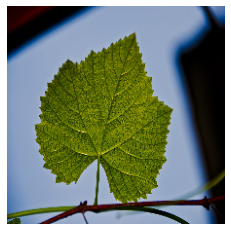

Pepaya
Anggur: 0.7182085420936346
Apel: 0.0018541626559454016
Ceri: 6.651588529348373
Delima: 0.0008230591447500046
Jamblang: 1.3909087516367435
Jambu Biji: 0.014436552010010928
Kedelai: 0.02001006796490401
Lemon: 0.036271201679483056
Mangga: 0.0008362198059330694
Pepaya: 91.16506576538086


In [41]:
model = vgg16_model.model
label_map = (vgg16_model.train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='daun-anggur2.jpg'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

# Save Model

In [46]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 40 kB 5.9 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [42]:
vgg16_model.model.save("asd", save_format='tf')

INFO:tensorflow:Assets written to: asd/assets


In [47]:
!tensorflowjs_converter --input_format tf_saved_model --output_format tfjs_graph_model asd vgg16_saved_model

2022-06-07 08:39:14.320473: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-07 08:39:15.869340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.015684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.108850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.598163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:19.941624: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
Writing weight file vgg16_saved_model/model.json...


In [48]:
!zip -r vgg16_best_model_last.zip vgg16_saved_model

  adding: vgg16_saved_model/ (stored 0%)
  adding: vgg16_saved_model/group1-shard16of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard2of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard10of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard3of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard7of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard25of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard8of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard27of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard12of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard28of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard17of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard20of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard23of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard5of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard14of28.bin (de

In [49]:
!cp vgg16_best_model_last.zip /content/drive/Shareddrives/Bangkit\ Capstone/Saved\ model

# Miscellaneous

In [32]:
vgg16_model.train_generator.class_indices

{'Anggur': 0,
 'Apel': 1,
 'Ceri': 2,
 'Delima': 3,
 'Jamblang': 4,
 'Jambu Biji': 5,
 'Kedelai': 6,
 'Lemon': 7,
 'Mangga': 8,
 'Pepaya': 9}

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img =  cv2.imread('/istockphoto-584504750-1024x1024.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}